In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ten

In [7]:

datadir = 'Data/male/'

In [8]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

def read_data(globpattern):
    ifiles = glob.glob(globpattern) #'Data/AAI/tiffs_FSS_24h*.mm')
    print(ifiles)
    ammdict = dict()
    for i in ifiles:
        amm = read_mm(i)
        amm_m = amm.mean(axis=(1,2), keepdims=True)
        amm_std = amm.std(axis=(1,2), keepdims=True)
        amm = (amm - amm_m)/amm_std
        print(amm.shape)
        ammdict[i.split('/')[-1]] = amm
   
    return ammdict

ammdict = read_data('Data/male/*.mm')

['Data/male/male_Snail_Male_R3.mm', 'Data/male/male_Snail_Male_R1.mm', 'Data/male/male_Snail_Male_R5.mm', 'Data/male/male_Snail_Male_R4.mm', 'Data/male/male_Snail_Male_R2.mm']
(4773, 64, 64, 3)
(6832, 64, 64, 3)
(7755, 64, 64, 3)
(5917, 64, 64, 3)
(7225, 64, 64, 3)


In [9]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


dict_keys(['male_Snail_Male_R3.mm', 'male_Snail_Male_R1.mm', 'male_Snail_Male_R5.mm', 'male_Snail_Male_R4.mm', 'male_Snail_Male_R2.mm'])


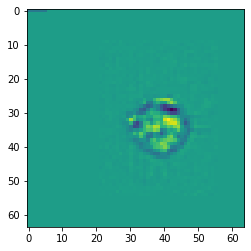

In [13]:
print(ammdict.keys())
plt.imshow(ammdict['male_Snail_Male_R3.mm'][2567,:,:,0])

In [14]:
cpdir = 'Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

cpmeta = cpdir + checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, cpdir + checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/best-checkpoint-21300


In [15]:
pq = 'dense_1/BiasAdd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(128,) dtype=float32>]


In [16]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

In [17]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [18]:
#data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

In [19]:
for k, v in ammdict.items():
    #print(k, v.shape)
    amm = ammdict[k]
    mask = np.any(np.isnan(amm), axis=(1,2,3))
    amm = amm[~mask]
    ammdict[k] = amm

In [20]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
adflist = list()
d2list = list()
for k, v in ammdict.items():
    d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:v[:, 16:48, 16:48, :]})
    d2list.append(r2)
    p2x = np.argmax(p2, axis=-1)
    s = k.split('_')
    dataset = k #"{} {} {}".format(s[1], s[2], s[3][0])
    xdf = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1), 'dataset':dataset})
    adflist.append(xdf)

adf = pd.concat(adflist, axis=0)
d2array = np.concatenate(d2list)
d2array.shape

(32502, 128)

In [21]:

#sns.distplot(adf['smmax'])


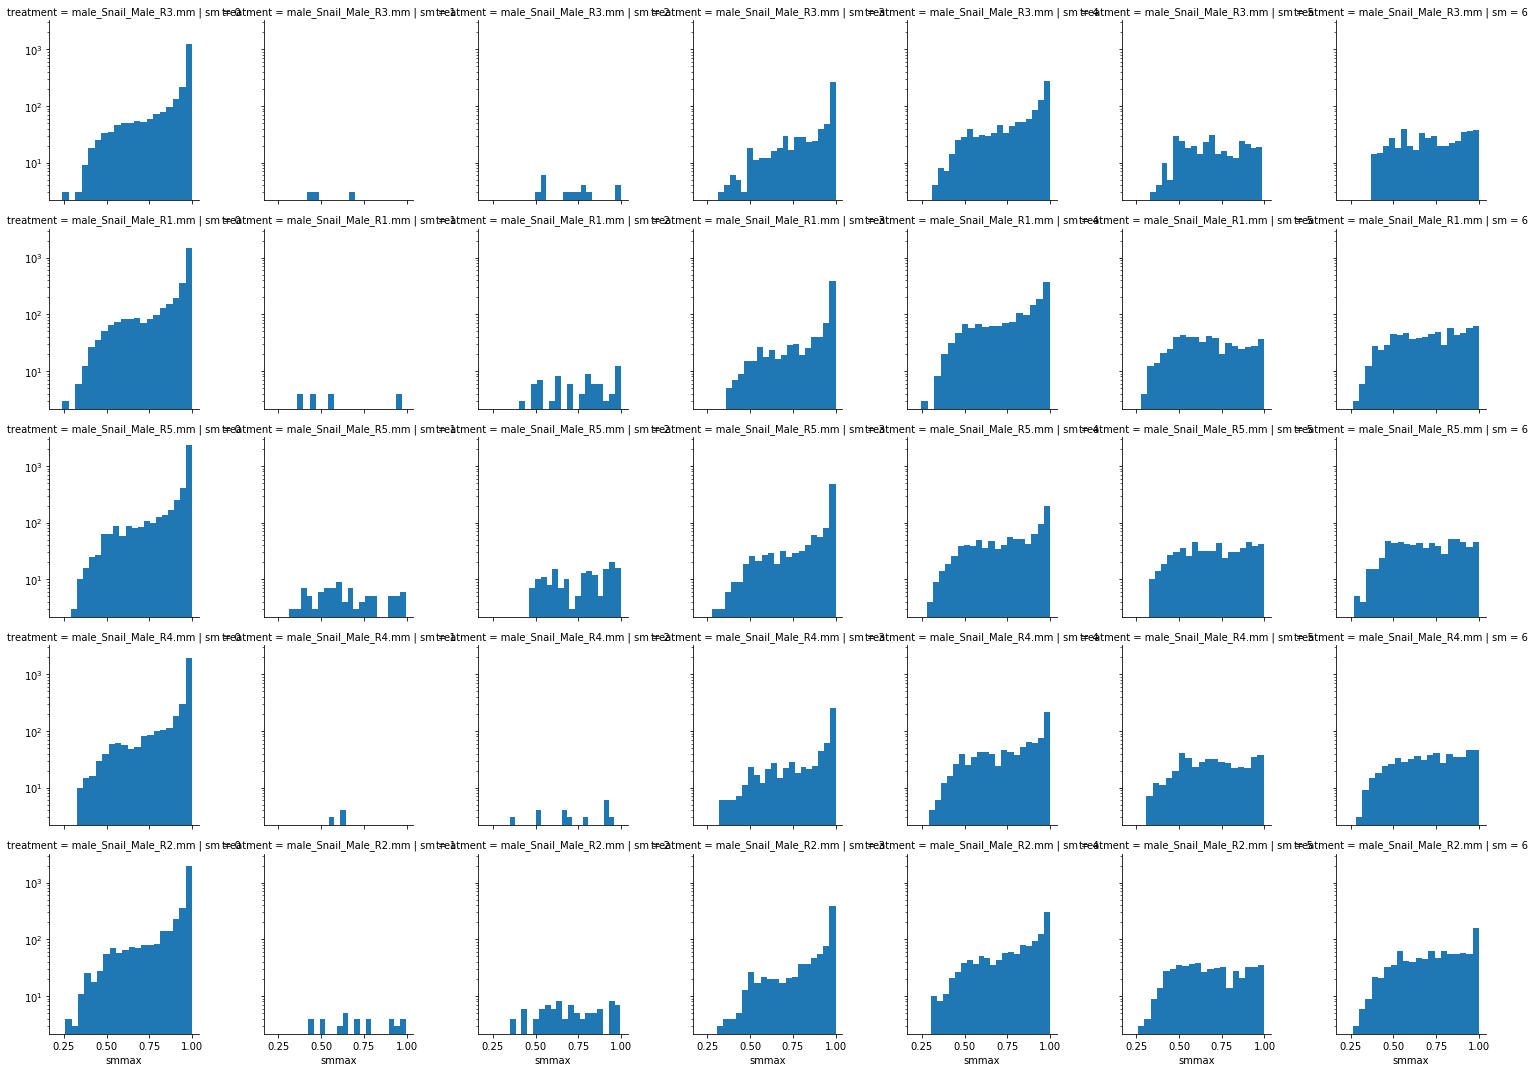

In [22]:
adf['treatment'] = adf['dataset'].str.split("h ", expand=True)[0]
g = sns.FacetGrid(adf, col='sm', row='treatment')
g = g.map(plt.hist, "smmax", bins=20, log=True)

In [23]:
adf.to_pickle("phago_adf_pickle.pkl")

In [24]:
#gdf = adf.groupby(['sm', 'treatment', pd.cut(adf["smmax"], [0, 0.4, 1])]).agg({'dataset':'count'})
binlabs = ["low", "high"]
adf['bin'] = pd.cut(adf["smmax"], [0, 0.3, 1], labels=binlabs)
print(adf.head())

topv = adf.groupby(['dataset', 'sm', 'bin']).agg('count').reset_index()
print(topv.head())

high = topv[topv.loc[:,'bin'] == 'high'].copy().reindex()
bdf = topv[topv.loc[:, 'bin'] == 'low'].copy().reindex()
#bdf = bdf.drop('dataset', axis=1)
print(bdf.head())
bdf.columns = ['dataset', 'treatment', 'class', 'bin', 'low']

bdf['high'] = list(high.smmax.copy())

bdf['ratio'] = bdf.low/(bdf.low + bdf.high)
bdf = bdf.reindex()
bdf = bdf.drop('treatment', axis=1)
print(adf.smmax.min(), type(bdf))
print(bdf.head(10))
print(bdf.describe())
#bdf.fillna(0).to_csv('phago_low_prob.csv')




   sm     smmax                dataset              treatment   bin
0   6  0.746722  male_Snail_Male_R3.mm  male_Snail_Male_R3.mm  high
1   0  0.888851  male_Snail_Male_R3.mm  male_Snail_Male_R3.mm  high
2   0  0.811636  male_Snail_Male_R3.mm  male_Snail_Male_R3.mm  high
3   0  0.885640  male_Snail_Male_R3.mm  male_Snail_Male_R3.mm  high
4   0  0.971806  male_Snail_Male_R3.mm  male_Snail_Male_R3.mm  high
                 dataset  sm   bin   smmax  treatment
0  male_Snail_Male_R1.mm   0   low     4.0        4.0
1  male_Snail_Male_R1.mm   0  high  3103.0     3103.0
2  male_Snail_Male_R1.mm   1   low     1.0        1.0
3  male_Snail_Male_R1.mm   1  high    31.0       31.0
4  male_Snail_Male_R1.mm   2   low     1.0        1.0
                 dataset  sm  bin  smmax  treatment
0  male_Snail_Male_R1.mm   0  low    4.0        4.0
2  male_Snail_Male_R1.mm   1  low    1.0        1.0
4  male_Snail_Male_R1.mm   2  low    1.0        1.0
6  male_Snail_Male_R1.mm   3  low    1.0        1.0
8  male_

In [25]:
aggs = adf.groupby(['sm', 'dataset']).agg('count').reset_index()

In [26]:
aggs.to_csv("/n/core/micro/nro/rop/cjw/Galleries/snail-male_20191016.csv")

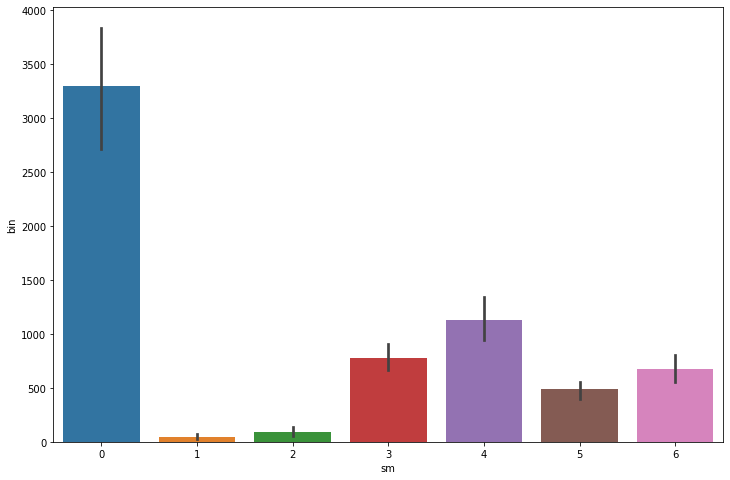

In [27]:
plt.figure(figsize=(12, 8))
sns.barplot(x='sm', y='bin', data=aggs)

In [29]:
aggs

,sm,dataset,smmax,treatment,bin
0,0,male_Snail_Male_R1.mm,3107,3107,3107
1,0,male_Snail_Male_R2.mm,3590,3590,3590
2,0,male_Snail_Male_R3.mm,2293,2293,2293
3,0,male_Snail_Male_R4.mm,3273,3273,3273
4,0,male_Snail_Male_R5.mm,4219,4219,4219
5,1,male_Snail_Male_R1.mm,32,32,32
6,1,male_Snail_Male_R2.mm,50,50,50
7,1,male_Snail_Male_R3.mm,26,26,26
8,1,male_Snail_Male_R4.mm,31,31,31
9,1,male_Snail_Male_R5.mm,98,98,98


In [83]:
import umap

emb1 = umap.UMAP(n_neighbors=8, min_dist=.001).fit_transform(d2array)
#emb2 = umap.UMAP(n_neighbors=12, min_dist=.1).fit_transform(r2)
adf['x'] = emb1[:,0]
adf['y'] = emb1[:, 1]

#df2['x'] = emb2[:,0]
#df2['y'] = emb2[:, 1]

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/deep/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


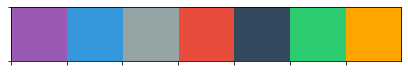

In [84]:
import seaborn as sns

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "orange"]
sns.palplot(sns.color_palette(flatui))

def scatter(df):
    df['s'] = df['smmax']
    df['s'] *= 10
    df['s'] = df['s'].map(int)

    plt.figure(figsize=(8,8))
    sns.scatterplot(x='x', y='y', hue='sm', s=2,
                    alpha=.4, edgecolor=None,
                    palette=flatui, legend='full', data=df)
    


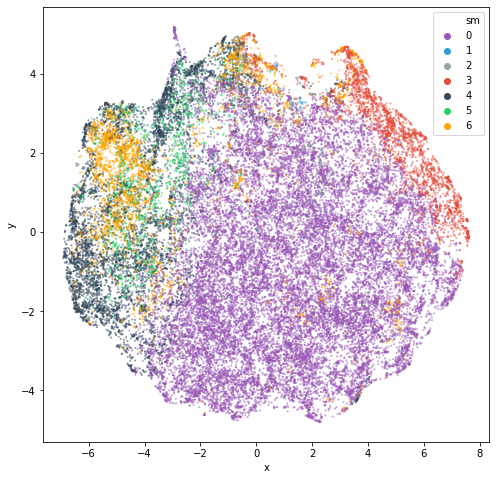

In [85]:
scatter(adf) #[adf['treatment'] == 'LPS 72'])

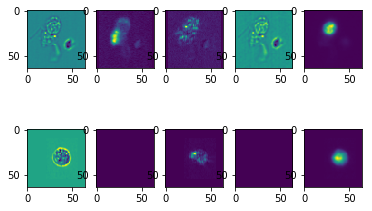

In [16]:
n = 38

for i in range(5):
    plt.subplot(2,5,i + 1)
    plt.imshow(data[n,:,:,i])
    plt.subplot(2,5,i + 1 + 5)
    plt.imshow(amm[n,:,:,i])

In [104]:
adf

,sm,smmax,dataset,x,y,s
0,0,0.999982,FSS 24h e,2.504132,-3.969366,9
1,0,0.981270,FSS 24h e,3.646953,-0.330614,9
2,0,0.957932,FSS 24h e,5.677839,-0.679615,9
3,4,0.971556,FSS 24h e,-2.666127,4.435254,9
4,5,0.908794,FSS 24h e,-2.036177,0.562304,9
5,0,0.791962,FSS 24h e,1.737364,3.334827,7
6,6,0.995296,FSS 24h e,-2.394324,2.046618,9
7,0,0.687566,FSS 24h e,2.657469,-3.841390,6
8,0,0.998909,FSS 24h e,4.580183,-1.930697,9
9,0,0.807004,FSS 24h e,1.104221,-0.399460,8


In [35]:
cn = 2

def gallery(df, images, cn, threshold):
    xdf = df[df['smmax'] > threshold]
    cnums = xdf[xdf['sm'] == cn].index
    cnums = np.array(cnums)
    np.random.shuffle(cnums)

    index = 1
    counter = 0

    if len(cnums) > 20:
        num_x = 20
    else:
        num_x = len(cnums)

    print(num_x)
    plt.figure(figsize=(4,1.3*num_x))
    for inum in cnums:
        #print(inum)
        #print(p[inum].max())
        for i in range(3):
            plt.subplot(num_x,3,index)
            plt.imshow(images[inum,:,:,i], cmap='gray')
            plt.axis('off')
            index += 1
        counter += 1
        if counter >= 20:
            break

    xdf[xdf['sm'] == cn].head()
    

20
20
20
20
20
20
20
20
20
20
20
20
20
20


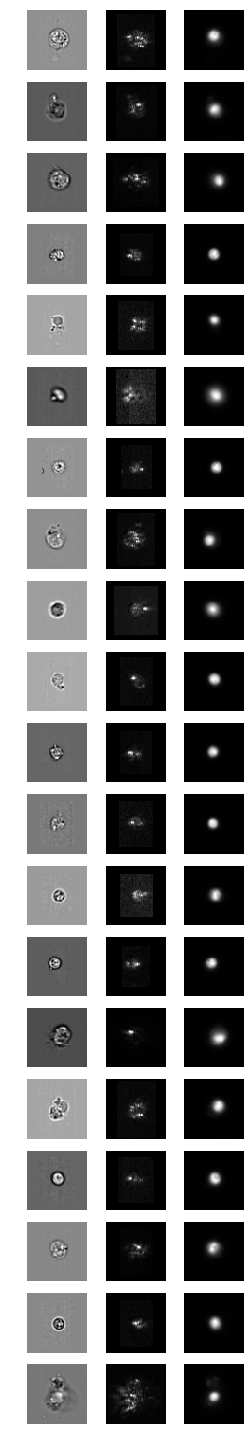

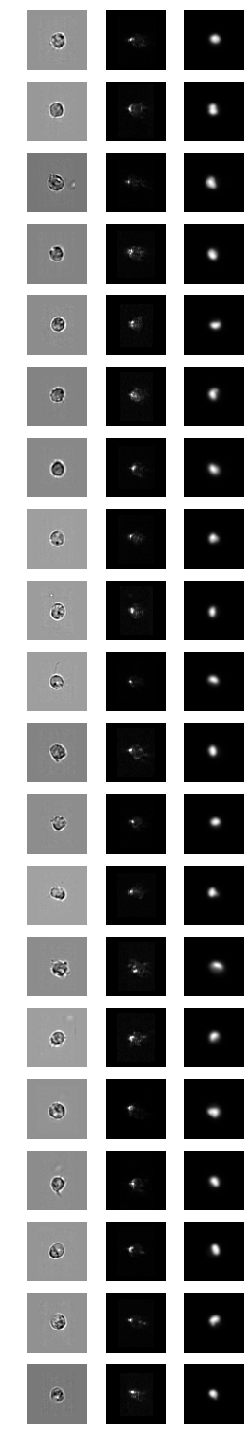

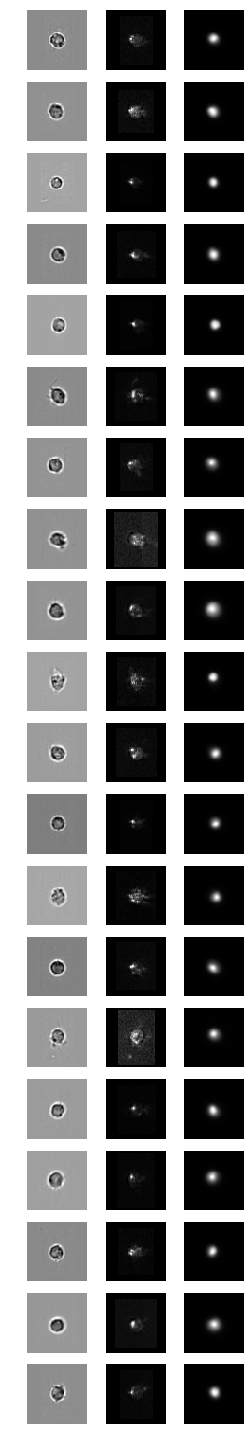

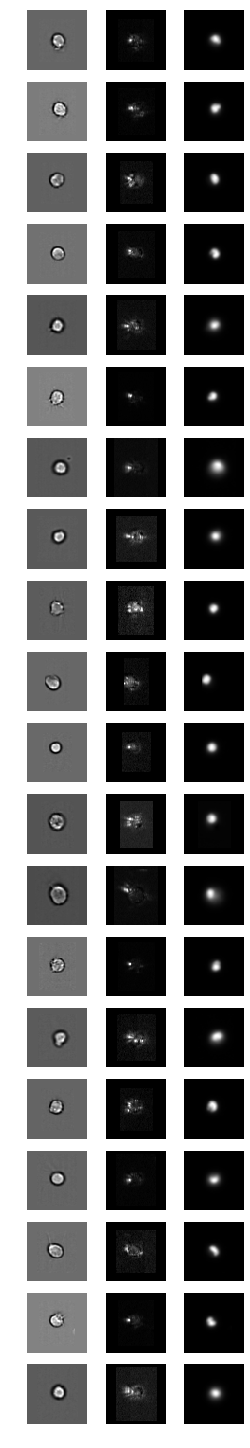

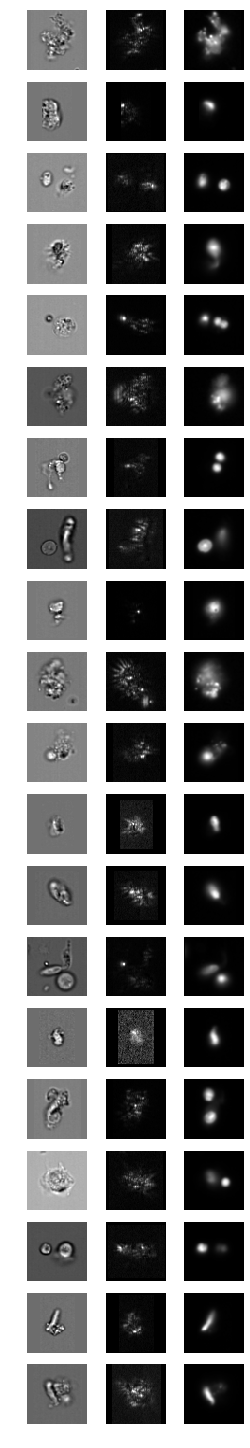

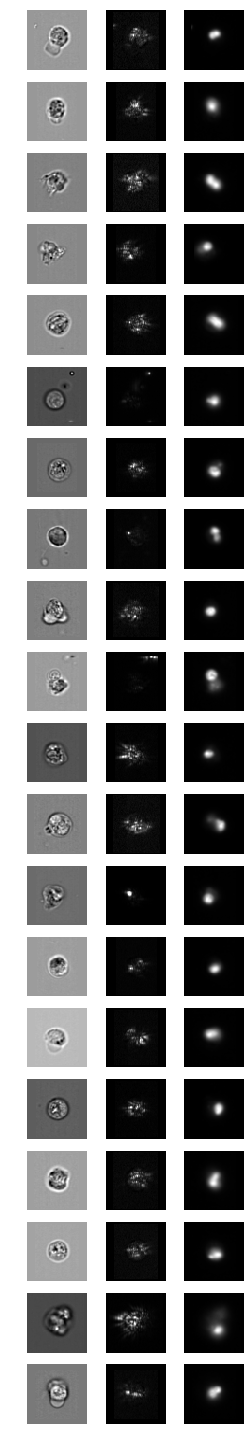

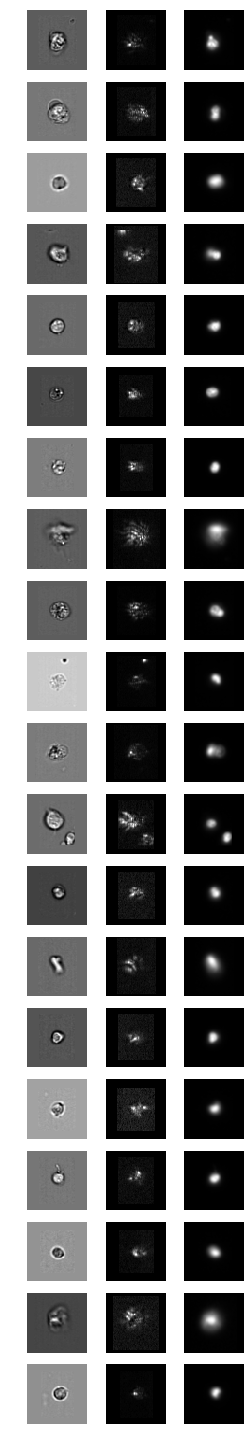

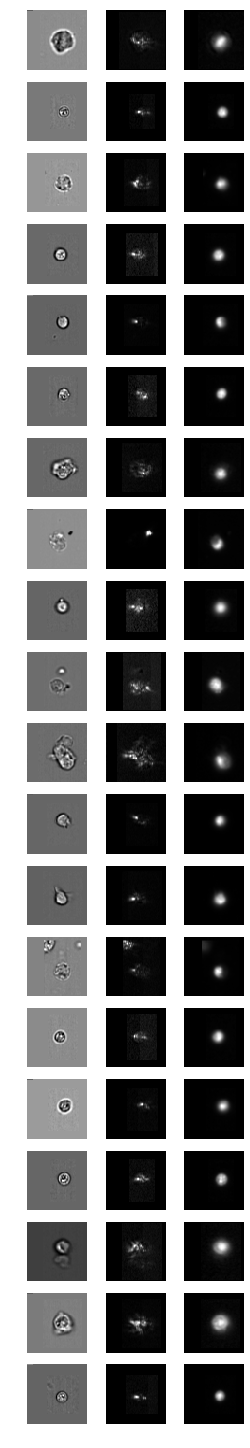

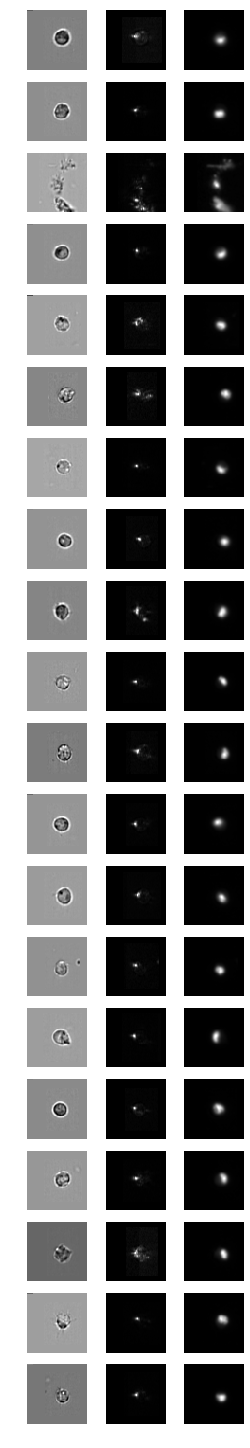

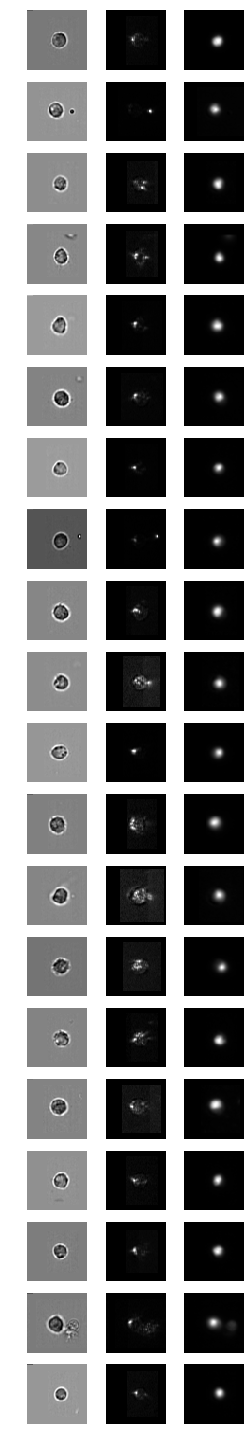

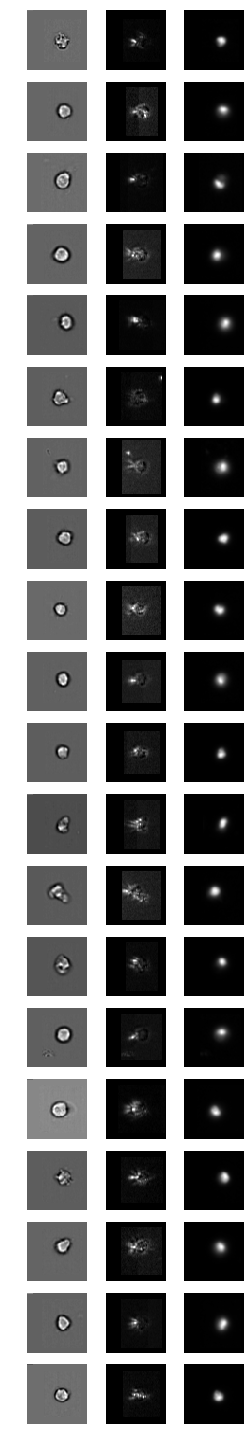

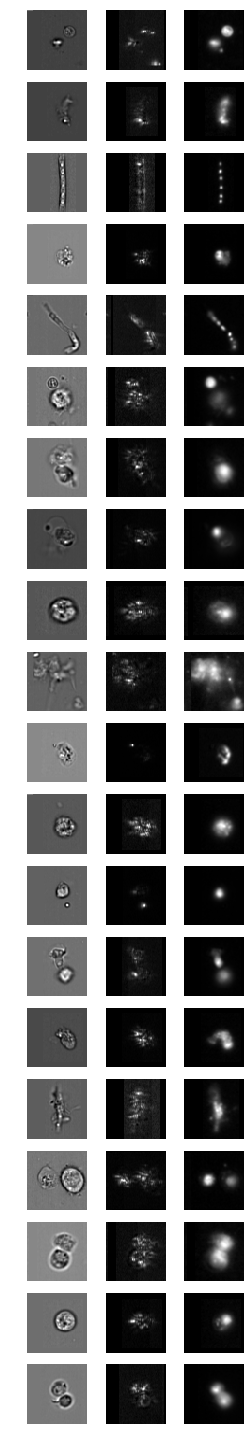

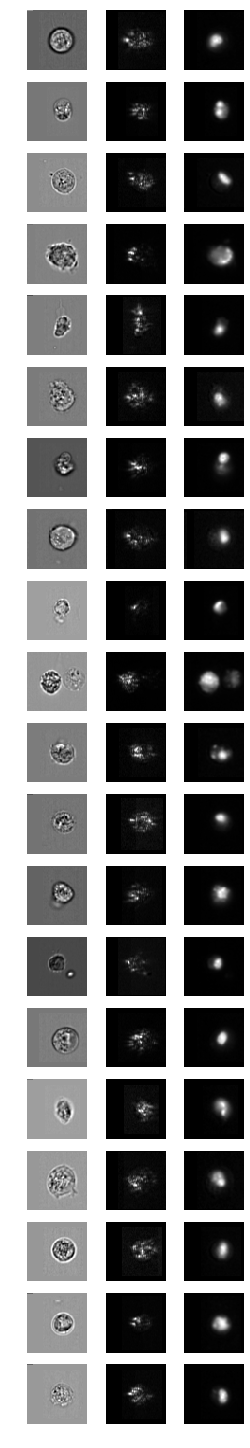

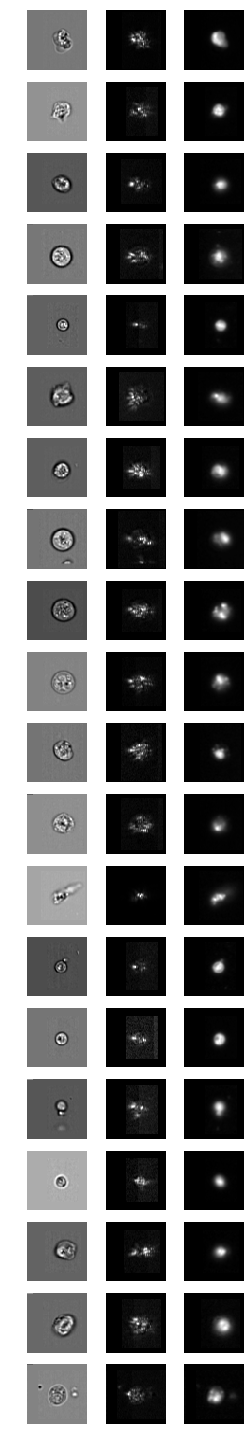

In [137]:
import os

plt.ioff()
gdir = 'Graphics/gallery_fss24/'
try:
    os.makedirs(gdir)
except:
    print('can\'t make directory')
    
for i in range(df1['gtc'].max() + 1):
    gallery(df1, data, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-1', i)
    plt.savefig(fname, bbox_inches='tight')
    
for i in range(df2['sm'].max() + 1):
    gallery(df2, amm, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-2', i)
    plt.savefig(fname, bbox_inches='tight')
    
plt.ion()

20


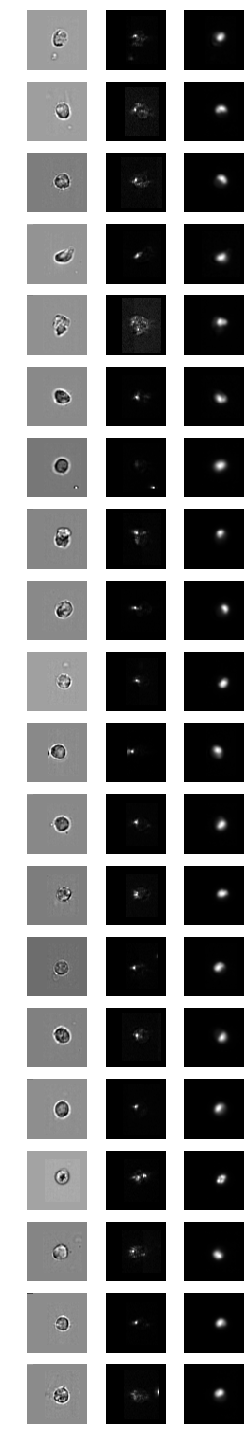

In [37]:
gallery(df2, amm, 1, .85)

In [65]:
from sklearn.manifold import TSNE
ts2 = TSNE().fit_transform(r2)

In [66]:
ts1 = TSNE().fit_transform(r1)

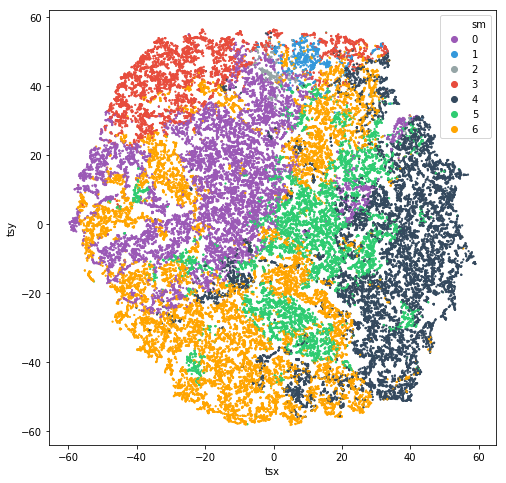

In [69]:

df2['tsx'] = ts2[:,0]
df2['tsy'] = ts2[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df2)

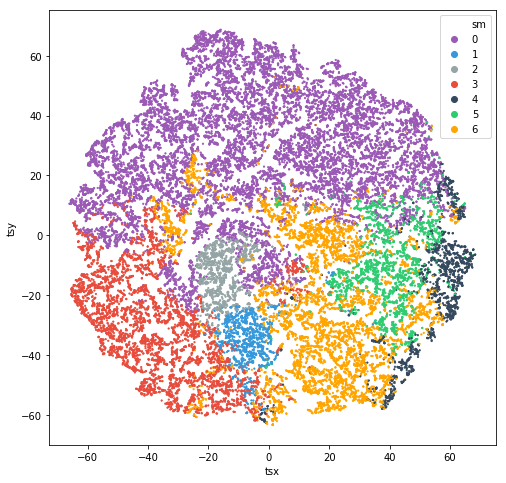

In [70]:
df1['tsx'] = ts1[:,0]
df1['tsy'] = ts1[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df1)